# **VGG에서 3x3 Convolution과 7x7 Convolution의 비교 분석**

본 프로젝트는 VGG 구조에서 사용되는 3x3 Convolution 계층을 7x7 Convolution으로 대체할 경우, **파라미터 수**, **연산 시간**, **분류 성능** 측면에서 어떤 차이가 발생하는지를 CIFAR-10 데이터셋을 통해 실험적으로 분석하였다.

## 사전 지식

### 1. VGG 구조

VGG(VGGNet)는 2014년 ILSVRC(ImageNet Large Scale Visual Recognition Challenge)에서 옥스퍼드 대학의 Visual Geometry Group에 의해 제안된 합성곱 신경망(Convolutional Neural Network) 구조이다.
이 모델은 복잡한 구조 대신 일관되게 3x3 크기의 소형 필터를 반복적으로 사용하는 단순한 설계 방식을 통해 깊은 네트워크를 구성하고도 우수한 성능을 달성한 점에서 큰 의의를 가진다.

VGG의 핵심 설계는 다음과 같다.
- 동일한 크기의 Convolution 연산 반복: 전체 네트워크에 걸쳐 3x3 커널을 통일적으로 적용함으로써, 구조적 일관성을 유지하면서도 깊이를 효과적으로 증가시킬 수 있다.
- 연속된 작은 필터의 누적 receptive field 확보: 3x3 Conv를 2회 연속 적용하면 5x5, 3회 연속 적용 시 7x7에 해당하는 수용 영역을 확보할 수 있으며, 그 과정에서 더 많은 비선형성(ReLU)이 삽입되어 표현력이 향상된다.
- 계층적 특성 추출: Convolution과 ReLU, 그리고 MaxPooling을 반복적으로 조합하여, 저수준에서 고수준까지의 시각 정보를 점진적으로 추출한다.
- 공간 해상도 축소: MaxPooling(2x2, stride 2)을 주기적으로 적용하여 feature map의 크기를 줄이는 동시에 연산 효율을 개선한다.

### 2. 커널 크기와 파라미터 수

합성곱 계층의 연산 복잡도 및 파라미터 수는 커널 크기에 크게 영향을 받는다. 일반적으로 커널의 공간 크기가 커질수록 다음과 같은 변화가 발생한다.

- 3x3 커널
파라미터 수는 상대적으로 적고, 동일한 수용 영역을 여러 층에 걸쳐 누적적으로 확보함으로써 깊이 기반의 표현 학습이 가능하다.
이 방식은 네트워크의 비선형성 밀도를 높이고, 학습의 안정성과 표현력을 동시에 확보하는 데 유리하다.

- 7x7 커널
단일 계층에서 더 넓은 수용 영역을 갖게 되어 지역적 패턴을 빠르게 통합할 수 있으나,
필터당 파라미터 수는 3x3 커널 대비 약 5.4배 많아지므로, 모델의 전체 크기 및 연산 비용이 급격히 증가한다.
또한, 깊이가 얕아지면서 네트워크의 비선형성이 감소하고, 학습 과정에서 과적합 또는 수렴 저하로 이어질 수 있다.


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import time
import os
import random
import numpy as np
from torch.optim.lr_scheduler import CosineAnnealingLR


# CONFIG

config = {
    "RANDOM_SEED": 42,
    "LEARNING_RATE": 1e-4,
    "BATCH_SIZE": 128,
    "NUM_EPOCHS": 100,
    "NUM_CLASSES": 10,
    "SAVE_BEST_MODEL": True,
    "BEST_MODEL_PATH": "checkpoints/vgg_best_model.pth",
    "DEVICE": "cuda:0" if torch.cuda.is_available() else "cpu",
    "EARLY_STOP_PATIENCE": 10,
    "EARLY_STOP_MIN_DELTA": 0.001
}

all_results = {}

In [3]:
import torch
import torch.nn as nn
from torchsummary import summary

class VGG16_3x3(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x32 -> 16x16

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16x16 -> 8x8

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 8x8 -> 4x4

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 4x4 -> 2x2

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 2x2 -> 1x1
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 1 * 1, 4096), # VGG16 원본의 첫 FC
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),        # VGG16 원본의 두번째 FC
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)  # 최종 분류
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

print("--- VGG16_3x3 Model ---")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_3x3 = VGG16_3x3(num_classes=10).to(device)
summary(model_3x3, (3, 32, 32)) # CIFAR-10 입력 이미지 크기 (채널, 높이, 너비)

--- VGG16_3x3 Model ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             Re

In [4]:
import torch
import torch.nn as nn
from torchsummary import summary

class VGG16_7x7(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=7, padding=3), # padding=3 for kernel_size=7 to maintain spatial dimensions
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x32 -> 16x16

            # Block 2
            nn.Conv2d(64, 128, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16x16 -> 8x8

            # Block 3
            nn.Conv2d(128, 256, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 8x8 -> 4x4

            # Block 4
            nn.Conv2d(256, 512, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 4x4 -> 2x2

            # Block 5
            nn.Conv2d(512, 512, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 2x2 -> 1x1
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

print("\n--- VGG16_7x7 Model ---")
model_7x7 = VGG16_7x7(num_classes=10).to(device)
summary(model_7x7, (3, 32, 32)) # CIFAR-10 입력 이미지 크기


--- VGG16_7x7 Model ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,472
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]         200,768
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]         401,536
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         802,944
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]       1,605,888
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]       3,211,520
             R

In [5]:
# DATA

def get_dataloaders(batch_size=128):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


In [6]:
# TRAINING

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for x, y in loader:
        x, y = x.to(config["DEVICE"]), y.to(config["DEVICE"])
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        correct += pred.argmax(1).eq(y).sum().item()
        total += y.size(0)
    return running_loss / total, correct / total

def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(config["DEVICE"]), y.to(config["DEVICE"])
            pred = model(x)
            loss = criterion(pred, y)
            running_loss += loss.item() * x.size(0)
            correct += pred.argmax(1).eq(y).sum().item()
            total += y.size(0)
    return running_loss / total, correct / total

def train_model(model, train_loader, test_loader, optimizer, criterion, scheduler, exp_config):
    best_test_acc = 0.0
    total_train_time = 0.0
    epochs_no_improve = 0

    os.makedirs(os.path.dirname(config["BEST_MODEL_PATH"]), exist_ok=True)

    for epoch in range(config["NUM_EPOCHS"]):
        model.train()
        start_time = time.time()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(config["DEVICE"]), labels.to(config["DEVICE"])

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        epoch_time = time.time() - start_time
        total_train_time += epoch_time

        train_acc = correct_predictions / total_samples

        # Test accuracy
        test_loss, test_acc = evaluate(model, test_loader, criterion)

        print(f"Epoch {epoch+1:03d} | Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Time: {epoch_time:.1f}s")

        scheduler.step()

        # Save the best model and apply early stopping
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), exp_config.model_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve == config['EARLY_STOP_PATIENCE']:
                print(f"Early stopping at epoch {epoch+1} due to no improvement for {config['EARLY_STOP_PATIENCE']} epochs.")
                break

    print(f"Finished training for {exp_config.name}. Best Test Accuracy: {best_test_acc:.4f}")
    return best_test_acc, total_train_time


In [7]:
class ExperimentConfig:
    def __init__(self, name, seed, batch_size=128):
        self.name = name
        self.seed = seed
        self.batch_size = batch_size
        self.model_path = f"checkpoints/best_model_{name}.pth"

def set_all_seeds(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

def run_single_experiment(model_class, model_name, exp_config: ExperimentConfig):
    print(f"\n Running experiment: {exp_config.name} (Seed: {exp_config.seed})")
    set_all_seeds(exp_config.seed)

    train_loader, test_loader = get_dataloaders(config["BATCH_SIZE"])

    model = model_class(num_classes=config["NUM_CLASSES"]).to(config["DEVICE"])
    optimizer = optim.Adam(model.parameters(), lr=config["LEARNING_RATE"])
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config["NUM_EPOCHS"])

    best_acc, total_time = train_model(model, train_loader, test_loader, optimizer, criterion, scheduler, exp_config)

    total_params = sum(p.numel() for p in model.parameters())
    print(f"{model_name} - Total Parameters: {total_params / 1e6:.2f}M")

    return best_acc, total_time


In [23]:
import matplotlib.pyplot as plt
import numpy as np

def summarize_and_plot_results(results_3x3, results_7x7, seeds):
    # 최종 결과 출력
    print("\n=== Final Experiment Results ===")

    print("\n--- VGG16_3x3 ---")
    for i, seed in enumerate(seeds):
        print(f"Seed {seed}: Best Accuracy = {results_3x3['best_accuracies'][i]:.4f}, Total Training Time = {results_3x3['total_times'][i]:.1f}s")
    avg_acc_3x3 = np.mean(results_3x3['best_accuracies'])
    std_acc_3x3 = np.std(results_3x3['best_accuracies'])
    avg_time_3x3 = np.mean(results_3x3['total_times'])
    print(f"Average Best Accuracy: {avg_acc_3x3:.4f} (Std: {std_acc_3x3:.4f})")
    print(f"Average Total Training Time: {avg_time_3x3:.1f}s")

    print("\n--- VGG16_7x7 ---")
    for i, seed in enumerate(seeds):
        print(f"Seed {seed}: Best Accuracy = {results_7x7['best_accuracies'][i]:.4f}, Total Training Time = {results_7x7['total_times'][i]:.1f}s")
    avg_acc_7x7 = np.mean(results_7x7['best_accuracies'])
    std_acc_7x7 = np.std(results_7x7['best_accuracies'])
    avg_time_7x7 = np.mean(results_7x7['total_times'])
    print(f"Average Best Accuracy: {avg_acc_7x7:.4f} (Std: {std_acc_7x7:.4f})")
    print(f"Average Total Training Time: {avg_time_7x7:.1f}s")


    # 막대 그래프 시각화
    labels = ['VGG16_3x3', 'VGG16_7x7']
    avg_accuracies = [avg_acc_3x3, avg_acc_7x7]
    avg_times = [avg_time_3x3, avg_time_7x7]

    x = np.arange(len(labels))
    width = 0.35

    # 정확도 막대 그래프
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    rects1 = ax1.bar(x, avg_accuracies, width, label='Average Best Accuracy', color=['skyblue', 'lightcoral'])
    ax1.set_ylabel('Average Best Accuracy')
    ax1.set_title('Average Best Test Accuracy by Model Type')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels)
    ax1.set_ylim(min(avg_accuracies) * 0.9, max(avg_accuracies) * 1.1) # 정확도 범위 자동 조정
    ax1.legend()
    ax1.bar_label(rects1, fmt='%.4f', padding=3)
    fig1.tight_layout()
    plt.show()

    # 훈련 시간 막대 그래프
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    rects2 = ax2.bar(x, avg_times, width, label='Average Total Training Time (s)', color=['lightgreen', 'orange'])
    ax2.set_ylabel('Average Total Training Time (s)')
    ax2.set_title('Average Total Training Time by Model Type')
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels)
    ax2.legend()
    ax2.bar_label(rects2, fmt='%.1f', padding=3)
    fig2.tight_layout()
    plt.show()

In [17]:
# main

def main():
    seeds = [42]

    # 결과를 저장할 딕셔너리 초기화
    results_3x3 = {'best_accuracies': [], 'total_times': []}
    results_7x7 = {'best_accuracies': [], 'total_times': []}

    for i, seed in enumerate(seeds):
        print(f"\n Running experiments for Seed: {seed}")

        # VGG16_3x3 훈련
        exp_config_3x3 = ExperimentConfig(f"vgg16_3x3_seed_{seed}", seed=seed)
        best_acc_3x3, total_time_3x3 = run_single_experiment(VGG16_3x3, "VGG-3x3", exp_config_3x3)
        results_3x3['best_accuracies'].append(best_acc_3x3)
        results_3x3['total_times'].append(total_time_3x3)

        # VGG16_7x7 훈련
        exp_config_7x7 = ExperimentConfig(f"vgg16_7x7_seed_{seed}", seed=seed)
        best_acc_7x7, total_time_7x7 = run_single_experiment(VGG16_7x7, "VGG-7x7", exp_config_7x7)
        results_7x7['best_accuracies'].append(best_acc_7x7)
        results_7x7['total_times'].append(total_time_7x7)

    # 최종 결과 요약 및 시각화
    summarize_and_plot_results(results_3x3, results_7x7, seeds)


 Running experiments for Seed: 42

 Running experiment: vgg16_3x3_seed_42 (Seed: 42)
Epoch 001 | Train Acc: 0.1437, Test Acc: 0.2189, Time: 23.0s
Epoch 002 | Train Acc: 0.2534, Test Acc: 0.2921, Time: 22.9s
Epoch 003 | Train Acc: 0.3335, Test Acc: 0.3713, Time: 23.0s
Epoch 004 | Train Acc: 0.4321, Test Acc: 0.4925, Time: 22.9s
Epoch 005 | Train Acc: 0.5152, Test Acc: 0.5631, Time: 23.0s
Epoch 006 | Train Acc: 0.5782, Test Acc: 0.5739, Time: 22.9s
Epoch 007 | Train Acc: 0.6279, Test Acc: 0.6455, Time: 22.9s
Epoch 008 | Train Acc: 0.6607, Test Acc: 0.6586, Time: 23.0s
Epoch 009 | Train Acc: 0.6896, Test Acc: 0.6965, Time: 23.0s
Epoch 010 | Train Acc: 0.7139, Test Acc: 0.7182, Time: 23.0s
Epoch 011 | Train Acc: 0.7307, Test Acc: 0.7367, Time: 23.2s
Epoch 012 | Train Acc: 0.7519, Test Acc: 0.7392, Time: 23.0s
Epoch 013 | Train Acc: 0.7674, Test Acc: 0.7571, Time: 23.1s
Epoch 014 | Train Acc: 0.7801, Test Acc: 0.7553, Time: 23.0s
Epoch 015 | Train Acc: 0.7911, Test Acc: 0.7824, Time: 23.1s

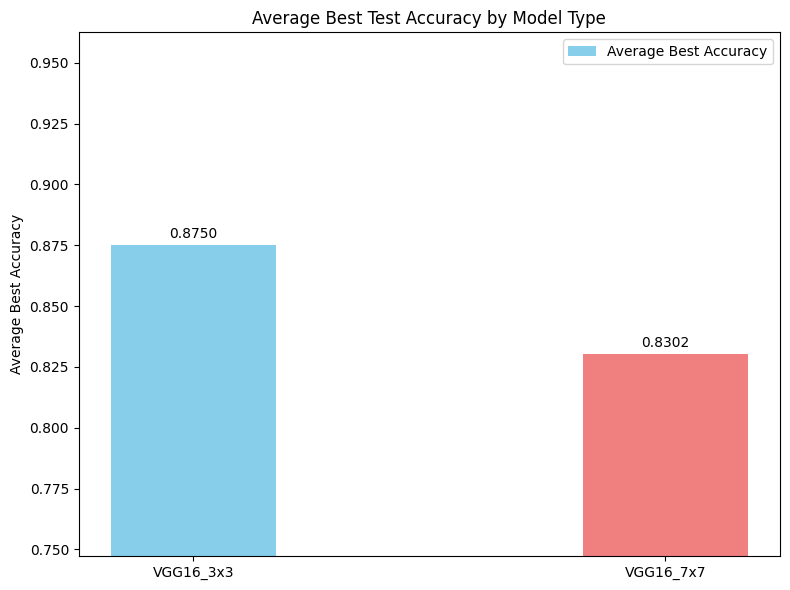

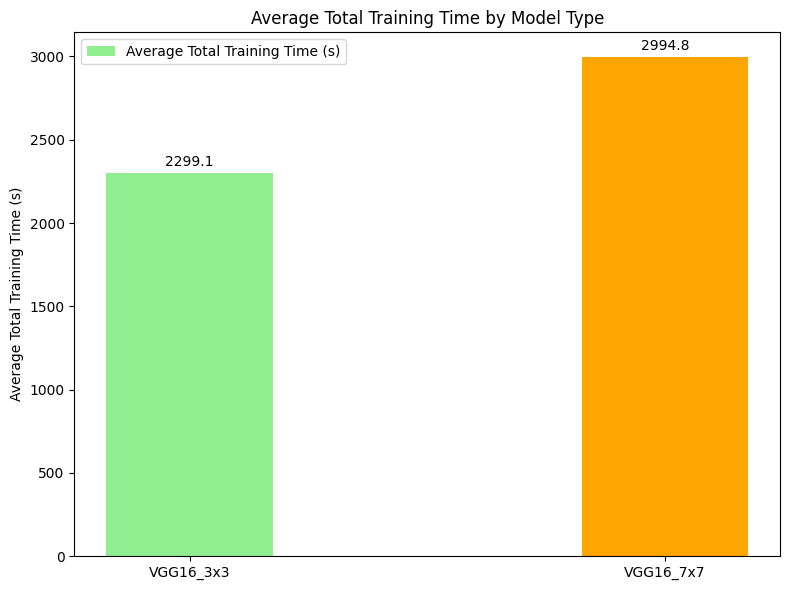

In [24]:
if __name__ == "__main__":
    main()

## 실험 결과

| **모델** | **실험 1** | **실험 2** | **실험 3** | **실험 4** | **실험 5** | **평균 정확도** | **시간 (평균, sec/epoch)** | **파라미터 수** |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| VGG 3x3 | 0.8750 | 0.8686 | 0.8720 | 0.8638 | 0.8663 | 0.8691 | 22.8 | 33,638,218 |
| VGG 7x7 | 0.8302 | 0.8200 | 0.8265 | 0.8266 | 0.8202 | 0.8247 | 29.8 | 99,018,058 |

## **분석**

1. **성능 차이**
    
    VGG 3x3 모델이 평균 정확도 86.9%로 VGG 7x7의 82.5%보다 약 4.4%p 높은 성능을 기록하였다. 이는 작은 커널을 반복적으로 쌓을 경우 더 많은 비선형성을 도입할 수 있어 표현력이 높아지기 때문이다.
    
2. **파라미터 수 차이**
    
    동일한 출력 채널 수를 가지는 경우, 커널 크기가 커질수록 파라미터 수가 기하급수적으로 증가한다. 7x7 커널을 적용한 모델은 3배에 가까운 파라미터 수를 가짐으로써 모델 크기와 메모리 사용량이 크게 늘어난다.
    
3. **연산 시간 차이**
    
    epoch당 학습 시간 또한 7x7 모델이 3x3 모델보다 약 30% 더 소요되었으며, 이는 커널 연산량 증가에 기인한다.
    
    연산 효율 측면에서도 작은 커널을 여러 개 조합하는 방식이 유리하다.


## **결론**

본 실험을 통해, VGG 구조에서 3x3 Convolution을 사용하는 것이 **성능**, **연산 효율**, **파라미터 효율성** 측면에서 7x7 Convolution보다 우수함을 확인하였다.

- 3x3 커널은 더 깊은 네트워크 구조를 가능하게 하고, 효율적인 학습과 높은 일반화 성능을 제공한다.
- 7x7 커널은 이론상 넓은 수용영역을 가지지만, 실제로는 학습 안정성과 성능 면에서 불리할 수 있다.

따라서, VGG 계열 네트워크에서는 작은 커널을 반복적으로 사용하는 전략이 더 바람직한 선택임을 실험적으로 검증하였다.